In [7]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm

In [8]:
# utility functions

def one_hot_encoded(y, num_class):
    n = y.shape[0]
    onehot = np.zeros((n, num_class), dtype="int32")
    for i in range(n):
        idx = y[i]
        onehot[i][idx] = 1
    return onehot


def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)  # both are not one hot encoded


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) # substract np.max for increase stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads


In [9]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

In [10]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        return np.maximum(X, 0)
    
    def backward(self, dout, mode):
        self.gradInput = dout.copy()
        self.gradInput[self.X <= 0] = 0
        return self.gradInput, []

In [11]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [17]:
class Linear():

    def __init__(self, in_size, out_size):

        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)  # for save input dispersion
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        self.X = X
        output = self.X.dot(self.W) + self.b
        return output
    
    def backward(self, dout, mode):
        self.gradW = self.X.T.dot(dout)
        self.gradB = np.mean(dout, axis=0)
        self.gradInput = dout.dot(self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

In [18]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
linear = Linear(12, 5)
f = lambda x: linear.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = linear.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.02126571  0.28449427  0.1133537   0.26291979]
 [ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.02126571  0.28449427  0.1133537   0.26291979]
 [ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.02126571  0.28449427  0.1133537   0.26291979]
 [ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.02126571  0.28449427  0.1133537   0.26291979]
 [ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.02126571  0.28449427  0.1133537   0.26291979]
 [ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.02126571  0.28449427  0.1133537   0.26291979]
 [ 0.08970912 -0.35909765  0.55279863 -1.05735945 -0.40480274  0.32397307
  -0.58552067  0.96558784  0.021

In [32]:
class CrossEntropyLoss(object):

    def forward(self, X, y):
        # y can only be 1 or 0
        self.m = y.shape[0]
        self.p = softmax(X)
        # -log(p_true)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        dx = self.p.copy()
        dx[range(self.m), y] -= 1
        dx /= self.m
        return dx  #, []

## NN implementation

In [33]:
class NN:

    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
    
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self,layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)


    def dispGradParam():
        print(self.grads)
    

    def clear_grad_param(self):
        self.grads = []

In [34]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    X, y = shuffle(X, y)

    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, ...]
        y_batch = y[i:i + minibatch_size, ...]

        minibatches.append((X_batch, y_batch))
    return minibatches


In [35]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        if verbose:
            print("Epoch {0}".format(i + 1))

        # iterate over mini batches
        for X_mini, y_mini in tqdm(minibatches):

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in tqdm(minibatches_val):
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates   

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))


            # early stopping with patience = 5 on val loss

            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)    


            print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(
                mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net


In [36]:

# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
model.add_layer(Linear(4, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 2))

model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)




  0%|                                                    | 0/1 [00:00<?, ?it/s]

(4, 4)
(4, 4)
Epoch 1
Loss = 0.6805414653455457 | Training Accuracy = 0.5 | Val Loss = 0.6780848822680364 | Val Accuracy = 0.5
Epoch 2
Loss = 0.6780848822680364 | Training Accuracy = 0.5 | Val Loss = 0.6760287504806334 | Val Accuracy = 0.5
Epoch 3
Loss = 0.6760287504806334 | Training Accuracy = 0.5 | Val Loss = 0.6740361673233132 | Val Accuracy = 0.5
Epoch 4
Loss = 0.6740361673233132 | Training Accuracy = 0.5 | Val Loss = 0.6720671941695777 | Val Accuracy = 0.5
Epoch 5
Loss = 0.6720671941695777 | Training Accuracy = 0.5 | Val Loss = 0.6701126196878172 | Val Accuracy = 0.5
Epoch 6
Loss = 0.6701126196878172 | Training Accuracy = 0.5 | Val Loss = 0.6681701109053776 | Val Accuracy = 0.5
Epoch 7
Loss = 0.6681701109053776 | Training Accuracy = 0.5 | Val Loss = 0.6662315837263987 | Val Accuracy = 0.5
Epoch 8
Loss = 0.6662315837263987 | Training Accuracy = 0.5 | Val Loss = 0.6643023123305332 | Val Accuracy = 0.5
Epoch 9
Loss = 0.6643023123305332 | Training Accuracy = 0.5 | Val Loss = 0.6623804

  0%|                                                    | 0/1 [00:00<?, ?it/s]

Loss = 0.650860373172665 | Training Accuracy = 0.5 | Val Loss = 0.6489421871140564 | Val Accuracy = 0.5
Epoch 17
Loss = 0.6489421871140564 | Training Accuracy = 0.5 | Val Loss = 0.6470228141226922 | Val Accuracy = 0.5
Epoch 18
Loss = 0.6470228141226922 | Training Accuracy = 0.5 | Val Loss = 0.6451017182817503 | Val Accuracy = 0.5
Epoch 19
Loss = 0.6451017182817503 | Training Accuracy = 0.5 | Val Loss = 0.6431783850544539 | Val Accuracy = 0.5
Epoch 20
Loss = 0.6431783850544539 | Training Accuracy = 0.5 | Val Loss = 0.6412523157287323 | Val Accuracy = 0.5
Epoch 21
Loss = 0.6412523157287323 | Training Accuracy = 0.5 | Val Loss = 0.6393230234208402 | Val Accuracy = 0.5
Epoch 22
Loss = 0.6393230234208402 | Training Accuracy = 0.5 | Val Loss = 0.6373900301764942 | Val Accuracy = 0.5
Epoch 23
Loss = 0.6373900301764942 | Training Accuracy = 0.5 | Val Loss = 0.6354561743364382 | Val Accuracy = 0.5
Epoch 24
Loss = 0.6354561743364382 | Training Accuracy = 0.5 | Val Loss = 0.6335358326389839 | Val

  0%|                                                    | 0/1 [00:00<?, ?it/s]

Loss = 0.627663609972201 | Training Accuracy = 0.5 | Val Loss = 0.6256993691734865 | Val Accuracy = 0.5
Epoch 29
Loss = 0.6256993691734865 | Training Accuracy = 0.5 | Val Loss = 0.6237387923402246 | Val Accuracy = 0.5
Epoch 30
Loss = 0.6237387923402246 | Training Accuracy = 0.5 | Val Loss = 0.6217545332289932 | Val Accuracy = 0.5
Epoch 31
Loss = 0.6217545332289932 | Training Accuracy = 0.5 | Val Loss = 0.6197672010868542 | Val Accuracy = 0.5
Epoch 32
Loss = 0.6197672010868542 | Training Accuracy = 0.5 | Val Loss = 0.6177724745078642 | Val Accuracy = 0.5
Epoch 33
Loss = 0.6177724745078642 | Training Accuracy = 0.5 | Val Loss = 0.6157692046188377 | Val Accuracy = 0.5
Epoch 34
Loss = 0.6157692046188377 | Training Accuracy = 0.5 | Val Loss = 0.6137568394219995 | Val Accuracy = 0.5
Epoch 35
Loss = 0.6137568394219995 | Training Accuracy = 0.5 | Val Loss = 0.611725992732583 | Val Accuracy = 0.5
Epoch 36
Loss = 0.611725992732583 | Training Accuracy = 0.5 | Val Loss = 0.6096059473510969 | Val A

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 333.30it/s]


Loss = 0.5949576302377385 | Training Accuracy = 0.5 | Val Loss = 0.5928141176151535 | Val Accuracy = 0.5
Epoch 45
Loss = 0.5928141176151535 | Training Accuracy = 0.5 | Val Loss = 0.5906563096389889 | Val Accuracy = 0.5
Epoch 46
Loss = 0.5906563096389889 | Training Accuracy = 0.5 | Val Loss = 0.5884837285228761 | Val Accuracy = 0.5
Epoch 47
Loss = 0.5884837285228761 | Training Accuracy = 0.5 | Val Loss = 0.5862958954338499 | Val Accuracy = 0.5
Epoch 48
Loss = 0.5862958954338499 | Training Accuracy = 0.5 | Val Loss = 0.5840923308225745 | Val Accuracy = 0.5
Epoch 49
Loss = 0.5840923308225745 | Training Accuracy = 0.5 | Val Loss = 0.5818725538667536 | Val Accuracy = 0.5
Epoch 50
Loss = 0.5818725538667536 | Training Accuracy = 0.5 | Val Loss = 0.579636082687198 | Val Accuracy = 0.5
Epoch 51
Loss = 0.579636082687198 | Training Accuracy = 0.5 | Val Loss = 0.5773824341456926 | Val Accuracy = 0.5
Epoch 52
Loss = 0.5773824341456926 | Training Accuracy = 0.5 | Val Loss = 0.5751111240156791 | Val 

  0%|                                                    | 0/1 [00:00<?, ?it/s]


Epoch 58


  0%|                                                    | 0/1 [00:00<?, ?it/s]

Loss = 0.5635026596483819 | Training Accuracy = 0.5 | Val Loss = 0.5611105624395785 | Val Accuracy = 0.5
Epoch 59
Loss = 0.5611105624395785 | Training Accuracy = 0.5 | Val Loss = 0.5587219412261787 | Val Accuracy = 0.5
Epoch 60
Loss = 0.5587219412261787 | Training Accuracy = 0.5 | Val Loss = 0.5563830519956173 | Val Accuracy = 0.5
Epoch 61


  0%|                                                    | 0/1 [00:00<?, ?it/s]

Loss = 0.5563830519956173 | Training Accuracy = 0.5 | Val Loss = 0.55390440478572 | Val Accuracy = 0.5
Epoch 62
Loss = 0.55390440478572 | Training Accuracy = 0.5 | Val Loss = 0.5514151856920455 | Val Accuracy = 0.5
Epoch 63
Loss = 0.5514151856920455 | Training Accuracy = 0.5 | Val Loss = 0.5489081050612205 | Val Accuracy = 0.5
Epoch 64
Loss = 0.5489081050612205 | Training Accuracy = 0.5 | Val Loss = 0.546381830459112 | Val Accuracy = 0.5
Epoch 65
Loss = 0.546381830459112 | Training Accuracy = 0.5 | Val Loss = 0.5438357774681798 | Val Accuracy = 0.5
Epoch 66
Loss = 0.5438357774681798 | Training Accuracy = 0.5 | Val Loss = 0.541269215302384 | Val Accuracy = 0.5
Epoch 67
Loss = 0.541269215302384 | Training Accuracy = 0.5 | Val Loss = 0.5386742282204086 | Val Accuracy = 0.5
Epoch 68
Loss = 0.5386742282204086 | Training Accuracy = 0.5 | Val Loss = 0.536055097072506 | Val Accuracy = 0.5
Epoch 69
Loss = 0.536055097072506 | Training Accuracy = 0.5 | Val Loss = 0.5334110532147105 | Val Accuracy

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 666.61it/s]

Loss = 0.516216307431419 | Training Accuracy = 1.0 | Val Loss = 0.5140236176583617 | Val Accuracy = 1.0
Epoch 78
Loss = 0.5140236176583617 | Training Accuracy = 0.5 | Val Loss = 0.5126500007132325 | Val Accuracy = 0.5
Epoch 79
Loss = 0.5126500007132325 | Training Accuracy = 1.0 | Val Loss = 0.5117612119879843 | Val Accuracy = 1.0
Epoch 80
Loss = 0.5117612119879843 | Training Accuracy = 0.5 | Val Loss = 0.5158902049029532 | Val Accuracy = 0.5
Epoch 81
Loss = 0.5158902049029532 | Training Accuracy = 1.0 | Val Loss = 0.5173318973445442 | Val Accuracy = 1.0
Epoch 82
Loss = 0.5173318973445442 | Training Accuracy = 0.5 | Val Loss = 0.5335779661677639 | Val Accuracy = 0.5
Epoch 83
Loss = 0.5335779661677639 | Training Accuracy = 1.0 | Val Loss = 0.5425657999599935 | Val Accuracy = 1.0
Epoch 84
Loss = 0.5425657999599935 | Training Accuracy = 0.5 | Val Loss = 0.6080577326992007 | Val Accuracy = 0.5
Epoch 85
Loss = 0.6080577326992007 | Training Accuracy = 1.0 | Val Loss = 0.5764106035758392 | Val

## Mnist training

In [37]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [38]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [39]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)


In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

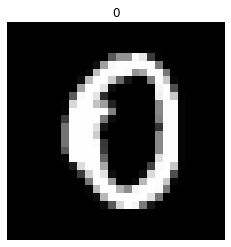

In [55]:
# visualize data

def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

In [72]:
print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
model.add_layer(Linear(X.shape[1], 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 100))
model.add_layer(ReLU())
model.add_layer(Linear(100, 10))

model = train(model, X_train , y_train, minibatch_size=128, epoch=100,
           learning_rate=0.0005, X_val=X_val, y_val=y_val)




(52500, 784)
(17500, 784)


  7%|██▊                                     | 29/411 [00:00<00:01, 284.28it/s]

Epoch 1


  9%|███▍                                    | 35/411 [00:00<00:01, 325.54it/s]

Loss = 1.431633889342587 | Training Accuracy = 0.8950857142857143 | Val Loss = 0.38727481318209017 | Val Accuracy = 0.8880571428571429
Epoch 2


 10%|███▉                                    | 41/411 [00:00<00:00, 407.91it/s]

Loss = 0.4139228111697467 | Training Accuracy = 0.9248190476190477 | Val Loss = 0.4197660455102953 | Val Accuracy = 0.9160571428571429
Epoch 3


  0%|                                                  | 0/411 [00:00<?, ?it/s]

Loss = 0.34771860367759433 | Training Accuracy = 0.9340190476190476 | Val Loss = 0.5904568468746436 | Val Accuracy = 0.9244
Epoch 4


 10%|███▉                                    | 40/411 [00:00<00:00, 394.04it/s]

Loss = 0.31708297176397776 | Training Accuracy = 0.9408380952380953 | Val Loss = 0.6889724344700928 | Val Accuracy = 0.9300571428571428
Epoch 5


 10%|███▉                                    | 40/411 [00:00<00:00, 392.11it/s]

Loss = 0.2978697507745847 | Training Accuracy = 0.9448190476190477 | Val Loss = 0.7063488434362837 | Val Accuracy = 0.9334857142857143
Epoch 6


 19%|███████▊                                | 80/411 [00:00<00:00, 393.46it/s]

Loss = 0.28383047955024154 | Training Accuracy = 0.9475809523809524 | Val Loss = 0.7705832812963108 | Val Accuracy = 0.9356
Epoch 7


 10%|███▉                                    | 40/411 [00:00<00:00, 399.95it/s]

Loss = 0.2715841601200997 | Training Accuracy = 0.9496190476190476 | Val Loss = 0.7025122293942774 | Val Accuracy = 0.9362285714285714
Epoch 8


  9%|███▊                                    | 39/411 [00:00<00:00, 382.30it/s]

Loss = 0.2628694540269401 | Training Accuracy = 0.9513333333333334 | Val Loss = 0.7279594204987526 | Val Accuracy = 0.9380571428571428
Epoch 9


 10%|███▉                                    | 41/411 [00:00<00:00, 379.58it/s]

Loss = 0.254150889497559 | Training Accuracy = 0.9512380952380952 | Val Loss = 0.7235332978839739 | Val Accuracy = 0.9382857142857143
Epoch 10


  4%|█▊                                      | 18/411 [00:00<00:02, 148.13it/s]

Loss = 0.24716888201926251 | Training Accuracy = 0.9538666666666666 | Val Loss = 0.6932310027508055 | Val Accuracy = 0.9393714285714285
Epoch 11


 19%|███████▊                                | 80/411 [00:00<00:00, 397.37it/s]

Loss = 0.24077033769965092 | Training Accuracy = 0.9542666666666667 | Val Loss = 0.6638115599936704 | Val Accuracy = 0.9398857142857143
Epoch 12


  8%|███                                     | 31/411 [00:00<00:01, 305.38it/s]

Loss = 0.2350529306736216 | Training Accuracy = 0.9539047619047619 | Val Loss = 0.6200093912269917 | Val Accuracy = 0.9404
Epoch 13


 10%|███▉                                    | 40/411 [00:00<00:00, 392.11it/s]

Loss = 0.22881770212710437 | Training Accuracy = 0.956247619047619 | Val Loss = 0.5884725196454867 | Val Accuracy = 0.9402285714285714
Epoch 14


  8%|███                                     | 31/411 [00:00<00:01, 275.52it/s]

Loss = 0.2231678527579224 | Training Accuracy = 0.9575428571428571 | Val Loss = 0.5804110179581458 | Val Accuracy = 0.9402857142857143
Epoch 15


 10%|███▉                                    | 40/411 [00:00<00:00, 394.04it/s]

Loss = 0.2170885375875786 | Training Accuracy = 0.9593333333333334 | Val Loss = 0.5452425148485329 | Val Accuracy = 0.9419428571428572
Epoch 16


  9%|███▊                                    | 39/411 [00:00<00:00, 388.01it/s]

Loss = 0.21318365683020718 | Training Accuracy = 0.9597523809523809 | Val Loss = 0.5423262483178157 | Val Accuracy = 0.9425142857142857
Epoch 17


  8%|███▎                                    | 34/411 [00:00<00:01, 333.29it/s]

Loss = 0.20961391445012045 | Training Accuracy = 0.9579047619047619 | Val Loss = 0.5300238701112422 | Val Accuracy = 0.9406285714285715
Epoch 18


  9%|███▌                                    | 37/411 [00:00<00:01, 368.11it/s]

Loss = 0.2054914222021353 | Training Accuracy = 0.9601333333333333 | Val Loss = 0.5076801837954769 | Val Accuracy = 0.9415428571428571
Epoch 19


  7%|██▋                                     | 28/411 [00:00<00:01, 275.83it/s]

Loss = 0.2004919416227193 | Training Accuracy = 0.9617904761904762 | Val Loss = 0.49632776341997775 | Val Accuracy = 0.9427428571428571
Epoch 20


  9%|███▌                                    | 36/411 [00:00<00:01, 356.39it/s]

Loss = 0.19709646824979085 | Training Accuracy = 0.9624952380952381 | Val Loss = 0.4939898651845801 | Val Accuracy = 0.9434857142857143
Epoch 21


  9%|███▊                                    | 39/411 [00:00<00:00, 389.95it/s]

Loss = 0.19381374654381373 | Training Accuracy = 0.9624571428571429 | Val Loss = 0.4937992428016054 | Val Accuracy = 0.9433714285714285
Epoch 22


  6%|██▍                                     | 25/411 [00:00<00:02, 151.96it/s]

Loss = 0.1904145617566779 | Training Accuracy = 0.9616 | Val Loss = 0.5060645274996552 | Val Accuracy = 0.9443428571428572
Epoch 23


  8%|███▎                                    | 34/411 [00:00<00:01, 339.96it/s]

Loss = 0.18831550217771256 | Training Accuracy = 0.9617904761904762 | Val Loss = 0.515441005774777 | Val Accuracy = 0.9426285714285715
Epoch 24


  9%|███▌                                    | 36/411 [00:00<00:01, 358.16it/s]

Loss = 0.1848875465877156 | Training Accuracy = 0.9626095238095238 | Val Loss = 0.52096631718239 | Val Accuracy = 0.9445142857142858
Epoch 25


  8%|███                                     | 32/411 [00:00<00:01, 315.23it/s]

Loss = 0.18112461163136692 | Training Accuracy = 0.9635428571428571 | Val Loss = 0.48367587229650333 | Val Accuracy = 0.944
Epoch 26


  0%|                                                  | 0/411 [00:00<?, ?it/s]

Loss = 0.17803023232058746 | Training Accuracy = 0.964704761904762 | Val Loss = 0.4819014022504071 | Val Accuracy = 0.9452
Epoch 27


  4%|█▌                                      | 16/411 [00:00<00:02, 146.77it/s]

Loss = 0.17616880658654926 | Training Accuracy = 0.9643047619047619 | Val Loss = 0.4504212092816643 | Val Accuracy = 0.944
Epoch 28


  8%|███                                     | 32/411 [00:00<00:01, 319.96it/s]

Loss = 0.17401824293853446 | Training Accuracy = 0.9648761904761904 | Val Loss = 0.459742743327121 | Val Accuracy = 0.9438857142857143
Epoch 29


 10%|███▉                                    | 40/411 [00:00<00:00, 395.99it/s]

Loss = 0.17177152331901352 | Training Accuracy = 0.9647619047619047 | Val Loss = 0.4412083585560452 | Val Accuracy = 0.9441714285714286
Epoch 30


 10%|███▉                                    | 41/411 [00:00<00:00, 409.95it/s]

Loss = 0.17005816966905876 | Training Accuracy = 0.9664761904761905 | Val Loss = 0.44511537003216217 | Val Accuracy = 0.9450857142857143
Epoch 31


 10%|████                                    | 42/411 [00:00<00:00, 409.70it/s]

Loss = 0.16757253529553015 | Training Accuracy = 0.9642095238095238 | Val Loss = 0.39387057520342744 | Val Accuracy = 0.9442285714285714
Epoch 32


 10%|███▉                                    | 40/411 [00:00<00:00, 399.95it/s]

Loss = 0.16560216674083164 | Training Accuracy = 0.964704761904762 | Val Loss = 0.4005762532699601 | Val Accuracy = 0.9438857142857143
Epoch 33


  9%|███▊                                    | 39/411 [00:00<00:00, 386.09it/s]

Loss = 0.16269360960946752 | Training Accuracy = 0.9670285714285715 | Val Loss = 0.4007308873416855 | Val Accuracy = 0.9457714285714286
Epoch 34


  9%|███▊                                    | 39/411 [00:00<00:00, 389.95it/s]

Loss = 0.16116825481396693 | Training Accuracy = 0.9657904761904762 | Val Loss = 0.40631859368186 | Val Accuracy = 0.9441714285714286
Epoch 35


  9%|███▋                                    | 38/411 [00:00<00:00, 374.34it/s]

Loss = 0.15920829253102253 | Training Accuracy = 0.9671428571428572 | Val Loss = 0.3824039750338884 | Val Accuracy = 0.9445714285714286
Epoch 36


  7%|██▋                                     | 27/411 [00:00<00:01, 230.74it/s]

Loss = 0.15712187899621058 | Training Accuracy = 0.9684761904761905 | Val Loss = 0.422245801895436 | Val Accuracy = 0.9455428571428571
Epoch 37


  9%|███▋                                    | 38/411 [00:00<00:00, 378.06it/s]

Loss = 0.1560781819102494 | Training Accuracy = 0.968247619047619 | Val Loss = 0.43854789952964346 | Val Accuracy = 0.9456
Epoch 38


 10%|███▉                                    | 40/411 [00:00<00:00, 395.99it/s]

Loss = 0.1545890534654993 | Training Accuracy = 0.9668952380952381 | Val Loss = 0.4105467376955189 | Val Accuracy = 0.9449714285714286
Epoch 39


  8%|███                                     | 31/411 [00:00<00:01, 293.80it/s]

Loss = 0.15187805031593732 | Training Accuracy = 0.9659809523809524 | Val Loss = 0.41935938300525216 | Val Accuracy = 0.9441714285714286
Epoch 40


  7%|██▋                                     | 27/411 [00:00<00:01, 267.29it/s]

Loss = 0.14997967387282476 | Training Accuracy = 0.9681904761904762 | Val Loss = 0.37575674720383706 | Val Accuracy = 0.9457714285714286
Epoch 41


  5%|██▏                                     | 22/411 [00:00<00:01, 216.72it/s]

Loss = 0.14895923220097668 | Training Accuracy = 0.9670285714285715 | Val Loss = 0.37486352488217506 | Val Accuracy = 0.9446285714285715
Epoch 42


  4%|█▋                                      | 17/411 [00:00<00:02, 168.30it/s]

Loss = 0.14795634789626022 | Training Accuracy = 0.9689142857142857 | Val Loss = 0.37934763579234915 | Val Accuracy = 0.9462857142857143
Epoch 43


  9%|███▋                                    | 38/411 [00:00<00:00, 374.34it/s]

Loss = 0.14548045175695584 | Training Accuracy = 0.9686476190476191 | Val Loss = 0.3141782489116172 | Val Accuracy = 0.9456
Epoch 44


  9%|███▋                                    | 38/411 [00:00<00:00, 378.06it/s]

Loss = 0.1447049866868195 | Training Accuracy = 0.9692952380952381 | Val Loss = 0.3422168444810018 | Val Accuracy = 0.9461142857142857
Epoch 45


  7%|██▉                                     | 30/411 [00:00<00:01, 246.88it/s]

Loss = 0.14323264565106322 | Training Accuracy = 0.9705142857142857 | Val Loss = 0.3366633661314584 | Val Accuracy = 0.9468571428571428
Epoch 46


 10%|███▉                                    | 40/411 [00:00<00:00, 397.96it/s]

Loss = 0.14258027090444067 | Training Accuracy = 0.9716761904761905 | Val Loss = 0.2818202355098435 | Val Accuracy = 0.9482857142857143
Epoch 47


  9%|███▌                                    | 37/411 [00:00<00:01, 273.03it/s]

Loss = 0.13976027368076827 | Training Accuracy = 0.9729904761904762 | Val Loss = 0.3244981700138178 | Val Accuracy = 0.9472
Epoch 48


 10%|███▉                                    | 41/411 [00:00<00:00, 401.91it/s]

Loss = 0.13941066042047448 | Training Accuracy = 0.9715238095238096 | Val Loss = 0.3419581576179242 | Val Accuracy = 0.9465142857142858
Epoch 49


  6%|██▌                                     | 26/411 [00:00<00:01, 258.67it/s]

Loss = 0.13872274844970992 | Training Accuracy = 0.9747619047619047 | Val Loss = 0.30059344946465666 | Val Accuracy = 0.9490857142857143
Epoch 50


  7%|██▊                                     | 29/411 [00:00<00:01, 244.70it/s]

Loss = 0.1360431143040704 | Training Accuracy = 0.9734285714285714 | Val Loss = 0.28103509267111565 | Val Accuracy = 0.9476571428571429
Epoch 51


  6%|██▏                                     | 23/411 [00:00<00:02, 174.88it/s]

Loss = 0.1374645509443257 | Training Accuracy = 0.9757904761904762 | Val Loss = 0.3286476956644792 | Val Accuracy = 0.9487428571428571
Epoch 52


  7%|██▋                                     | 27/411 [00:00<00:01, 267.29it/s]

Loss = 0.13652572989863443 | Training Accuracy = 0.974552380952381 | Val Loss = 0.2444585790663298 | Val Accuracy = 0.9489714285714286
Epoch 53


 10%|███▉                                    | 41/411 [00:00<00:00, 407.91it/s]

Loss = 0.13396586763694668 | Training Accuracy = 0.9756380952380952 | Val Loss = 0.31504027237966237 | Val Accuracy = 0.9497142857142857
Epoch 54


 10%|████                                    | 42/411 [00:00<00:00, 411.71it/s]

Loss = 0.13286292581113915 | Training Accuracy = 0.9766857142857143 | Val Loss = 0.2765758609333227 | Val Accuracy = 0.9483428571428572
Epoch 55


 10%|███▉                                    | 40/411 [00:00<00:00, 399.95it/s]

Loss = 0.13105219612971497 | Training Accuracy = 0.9758666666666667 | Val Loss = 0.2297561752792385 | Val Accuracy = 0.9472
Epoch 56


 10%|███▉                                    | 41/411 [00:00<00:00, 409.95it/s]

Loss = 0.13097694424545483 | Training Accuracy = 0.9763047619047619 | Val Loss = 0.20352256411919709 | Val Accuracy = 0.9481714285714286
Epoch 57


 10%|███▉                                    | 40/411 [00:00<00:00, 397.96it/s]

Loss = 0.12997161093340917 | Training Accuracy = 0.9780761904761904 | Val Loss = 0.22029222056562145 | Val Accuracy = 0.9487428571428571
Epoch 58


  0%|                                                  | 0/411 [00:00<?, ?it/s]

Loss = 0.12953737355659534 | Training Accuracy = 0.9750857142857143 | Val Loss = 0.21181162266540002 | Val Accuracy = 0.9466857142857142
Epoch 59


  9%|███▌                                    | 36/411 [00:00<00:01, 330.23it/s]

Loss = 0.12720121968373363 | Training Accuracy = 0.9791238095238095 | Val Loss = 0.20834617444043857 | Val Accuracy = 0.9490857142857143
Epoch 60


 10%|████                                    | 42/411 [00:00<00:00, 411.71it/s]

Loss = 0.1278270286594782 | Training Accuracy = 0.9789523809523809 | Val Loss = 0.21556849752139232 | Val Accuracy = 0.9491428571428572
Epoch 61


  3%|█▎                                      | 13/411 [00:00<00:03, 129.34it/s]

Loss = 0.12754153867851875 | Training Accuracy = 0.9769523809523809 | Val Loss = 0.13759222918116767 | Val Accuracy = 0.9477714285714286
Epoch 62


 10%|████▏                                   | 43/411 [00:00<00:00, 423.59it/s]

Loss = 0.1268605043367632 | Training Accuracy = 0.9795238095238096 | Val Loss = 0.1904704780759837 | Val Accuracy = 0.9477142857142857
Epoch 63


  9%|███▌                                    | 37/411 [00:00<00:01, 364.49it/s]

Loss = 0.1246823396328008 | Training Accuracy = 0.9764380952380952 | Val Loss = 0.2211659688853411 | Val Accuracy = 0.9464
Epoch 64


  9%|███▌                                    | 37/411 [00:00<00:01, 276.08it/s]

Loss = 0.12440340008434853 | Training Accuracy = 0.9815047619047619 | Val Loss = 0.21304159186608987 | Val Accuracy = 0.9476571428571429
Epoch 65


 10%|████                                    | 42/411 [00:00<00:00, 415.79it/s]

Loss = 0.12252039439509045 | Training Accuracy = 0.9791428571428571 | Val Loss = 0.15751721628380858 | Val Accuracy = 0.9474857142857143
Epoch 66


 10%|████                                    | 42/411 [00:00<00:00, 415.79it/s]

Loss = 0.12101143532270336 | Training Accuracy = 0.9775809523809523 | Val Loss = 0.14554128840221248 | Val Accuracy = 0.9473714285714285
Epoch 67


 10%|████▏                                   | 43/411 [00:00<00:00, 421.52it/s]

Loss = 0.12051427097890513 | Training Accuracy = 0.9793904761904761 | Val Loss = 0.12966241414215682 | Val Accuracy = 0.948
Epoch 68


 10%|███▉                                    | 41/411 [00:00<00:00, 403.89it/s]

Loss = 0.11914094165056399 | Training Accuracy = 0.9792190476190477 | Val Loss = 0.14861689242969467 | Val Accuracy = 0.9490285714285714
Epoch 69


 10%|███▉                                    | 41/411 [00:00<00:01, 311.75it/s]

Loss = 0.11856135329335153 | Training Accuracy = 0.9810476190476191 | Val Loss = 0.1260266947671004 | Val Accuracy = 0.9492
Epoch 70


 10%|████                                    | 42/411 [00:00<00:00, 413.74it/s]

Loss = 0.11653478533318407 | Training Accuracy = 0.9791238095238095 | Val Loss = 0.15479188932472387 | Val Accuracy = 0.9455428571428571
Epoch 71


 10%|████                                    | 42/411 [00:00<00:00, 417.86it/s]

Loss = 0.11830193723069947 | Training Accuracy = 0.9804 | Val Loss = 0.1310172981830084 | Val Accuracy = 0.9482857142857143
Epoch 72


  9%|███▌                                    | 36/411 [00:00<00:01, 354.63it/s]

Loss = 0.11606839432301726 | Training Accuracy = 0.9789142857142857 | Val Loss = 0.1628681827561412 | Val Accuracy = 0.9452571428571429
Epoch 73


 10%|███▉                                    | 40/411 [00:00<00:00, 386.42it/s]

Loss = 0.11705276321887784 | Training Accuracy = 0.9809142857142857 | Val Loss = 0.1417820004288707 | Val Accuracy = 0.9464571428571429
Epoch 74


 10%|███▉                                    | 41/411 [00:00<00:00, 407.91it/s]

Loss = 0.11572052929751848 | Training Accuracy = 0.9811428571428571 | Val Loss = 0.11603405458087405 | Val Accuracy = 0.9485714285714286
Epoch 75


 10%|████▏                                   | 43/411 [00:00<00:00, 427.81it/s]

Loss = 0.11480191880238723 | Training Accuracy = 0.9807428571428571 | Val Loss = 0.13202006400742758 | Val Accuracy = 0.9477142857142857
Epoch 76


 10%|████▏                                   | 43/411 [00:00<00:00, 429.95it/s]

Loss = 0.11456538080377134 | Training Accuracy = 0.9823619047619048 | Val Loss = 0.11154817068383016 | Val Accuracy = 0.9487428571428571
Epoch 77


 10%|████                                    | 42/411 [00:00<00:00, 415.79it/s]

Loss = 0.11072007769146304 | Training Accuracy = 0.9830476190476191 | Val Loss = 0.11035818129096109 | Val Accuracy = 0.9484571428571429
Epoch 78


  7%|██▋                                     | 28/411 [00:00<00:01, 277.19it/s]

Loss = 0.11245682235709657 | Training Accuracy = 0.9816 | Val Loss = 0.16723541451057136 | Val Accuracy = 0.9483428571428572
Epoch 79


  0%|                                                  | 0/411 [00:00<?, ?it/s]

Loss = 0.11082511076307076 | Training Accuracy = 0.9841333333333333 | Val Loss = 0.10893913150512968 | Val Accuracy = 0.9494857142857143
Epoch 80


 10%|███▉                                    | 41/411 [00:00<00:00, 403.89it/s]

Loss = 0.10856269226094785 | Training Accuracy = 0.9813142857142857 | Val Loss = 0.13537882559546335 | Val Accuracy = 0.948
Epoch 81


  7%|██▋                                     | 27/411 [00:00<00:01, 269.97it/s]

Loss = 0.10749883461761169 | Training Accuracy = 0.9827047619047619 | Val Loss = 0.12500530496207127 | Val Accuracy = 0.9487428571428571
Epoch 82


 10%|███▉                                    | 40/411 [00:00<00:00, 395.99it/s]

Loss = 0.10738944410151849 | Training Accuracy = 0.9840190476190476 | Val Loss = 0.11149890866653867 | Val Accuracy = 0.9492
Epoch 83


  9%|███▌                                    | 36/411 [00:00<00:01, 359.95it/s]

Loss = 0.10785881650271154 | Training Accuracy = 0.9841333333333333 | Val Loss = 0.10057270750195714 | Val Accuracy = 0.9493142857142857
Epoch 84


 10%|████                                    | 42/411 [00:00<00:00, 413.74it/s]

Loss = 0.10411940948309656 | Training Accuracy = 0.9834285714285714 | Val Loss = 0.11456238803394915 | Val Accuracy = 0.9494857142857143
Epoch 85


 10%|███▉                                    | 40/411 [00:00<00:00, 399.95it/s]

Loss = 0.1032857437332957 | Training Accuracy = 0.9836571428571429 | Val Loss = 0.09509008922254837 | Val Accuracy = 0.9497714285714286
Epoch 86


  8%|███▏                                    | 33/411 [00:00<00:01, 288.17it/s]

Loss = 0.10091830144917914 | Training Accuracy = 0.9817714285714285 | Val Loss = 0.0962040157310686 | Val Accuracy = 0.9481142857142857
Epoch 87


 10%|███▉                                    | 40/411 [00:00<00:00, 399.95it/s]

Loss = 0.10166007988597138 | Training Accuracy = 0.9804 | Val Loss = 0.10216559379273182 | Val Accuracy = 0.9458285714285715
Epoch 88


 10%|████▏                                   | 43/411 [00:00<00:00, 427.81it/s]

Loss = 0.10358931776862101 | Training Accuracy = 0.9828761904761905 | Val Loss = 0.1337180378020265 | Val Accuracy = 0.9492
Epoch 89


  8%|███                                     | 32/411 [00:00<00:01, 313.69it/s]

Loss = 0.10165385258541809 | Training Accuracy = 0.982895238095238 | Val Loss = 0.08494222467713672 | Val Accuracy = 0.9490857142857143
Epoch 90


  9%|███▋                                    | 38/411 [00:00<00:00, 376.19it/s]

Loss = 0.09888761139458123 | Training Accuracy = 0.9837333333333333 | Val Loss = 0.10571217113138867 | Val Accuracy = 0.9489714285714286
Epoch 91


 10%|███▉                                    | 40/411 [00:00<00:00, 394.04it/s]

Loss = 0.09771912408355383 | Training Accuracy = 0.9852952380952381 | Val Loss = 0.09257116027960781 | Val Accuracy = 0.9499428571428571
Epoch 92


  9%|███▊                                    | 39/411 [00:00<00:00, 389.95it/s]

Loss = 0.09795554843862882 | Training Accuracy = 0.982552380952381 | Val Loss = 0.10403092601747242 | Val Accuracy = 0.9489142857142857
Epoch 93


  7%|██▊                                     | 29/411 [00:00<00:01, 284.28it/s]

Loss = 0.0994676275152096 | Training Accuracy = 0.9810666666666666 | Val Loss = 0.09640993981053687 | Val Accuracy = 0.9495428571428571
Epoch 94


  7%|██▋                                     | 27/411 [00:00<00:01, 269.97it/s]

Loss = 0.09825424221018639 | Training Accuracy = 0.9827619047619047 | Val Loss = 0.08047524338671622 | Val Accuracy = 0.9490285714285714
Epoch 95


 10%|████▏                                   | 43/411 [00:00<00:00, 425.69it/s]

Loss = 0.0959229219694544 | Training Accuracy = 0.984 | Val Loss = 0.0965610052586482 | Val Accuracy = 0.9495428571428571
Epoch 96


  9%|███▋                                    | 38/411 [00:00<00:00, 376.19it/s]

Loss = 0.09950017469799938 | Training Accuracy = 0.9855238095238095 | Val Loss = 0.08904063660212622 | Val Accuracy = 0.9508571428571428
Epoch 97


  9%|███▍                                    | 35/411 [00:00<00:01, 297.83it/s]

Loss = 0.09488443703392384 | Training Accuracy = 0.9878476190476191 | Val Loss = 0.09291389704376296 | Val Accuracy = 0.9517714285714286
Epoch 98


 10%|████▏                                   | 43/411 [00:00<00:00, 423.59it/s]

Loss = 0.09544094777276312 | Training Accuracy = 0.9858095238095238 | Val Loss = 0.08700739569769485 | Val Accuracy = 0.9501714285714286
Epoch 99


  8%|███▏                                    | 33/411 [00:00<00:01, 302.71it/s]

Loss = 0.09411568396485338 | Training Accuracy = 0.9872571428571428 | Val Loss = 0.07842203428735965 | Val Accuracy = 0.9509142857142857
Epoch 100


100%|███████████████████████████████████████| 137/137 [00:00<00:00, 981.95it/s]


Loss = 0.09341279400657548 | Training Accuracy = 0.9844571428571428 | Val Loss = 0.08120387188436466 | Val Accuracy = 0.9489714285714286


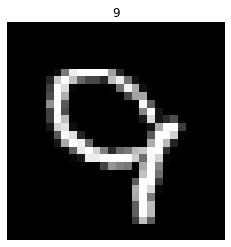

In [84]:
# visualize prediction 

vis_idx = 5
pred = model.predict(X_val[vis_idx])
#vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])

In [85]:
t = model.layers[0].W.mean(axis=1).reshape(28,28)
t -= t.min()
t /= t.max()
t *= 255
t = t.astype(np.int8)

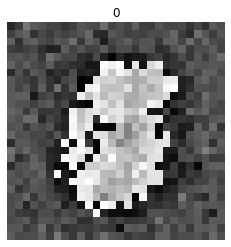

In [86]:
vis(t, 0)

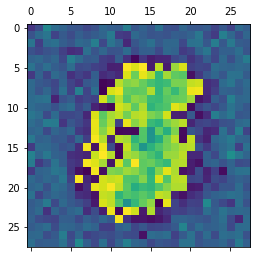

In [88]:
plt.matshow(t)

# TODO:
1) Add computational graph instead of list, model saving/loading, more optimizers, shedulers loss functions, operations, gpu support, utility tools ...

... Or simply use Pytorch/TF/whatever